In [116]:
# === IMPORTS & SETUP ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
from datetime import datetime
from pathlib import Path
from dotenv import load_dotenv
import os

from sqlalchemy import create_engine
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# === HELPER FUNCTIONS ===
def find_project_root(markers=(".env", "pyproject.toml", ".git")):
    start = Path.cwd().resolve()
    for parent in [start, *start.parents]:
        if any((parent / m).exists() for m in markers):
            return parent
    raise RuntimeError("Project root not found.")

def calculate_smape(actual, predicted):
    return np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted))) * 100

# === LOAD DATA ===
project_root = find_project_root()
load_dotenv(project_root / '.env')

DATABASE_URL = os.getenv("DATABASE_URL_ALEMBIC") or os.getenv("DATABASE_URL")
if not DATABASE_URL:
    raise ValueError("DATABASE_URL not set in .env")

engine = create_engine(DATABASE_URL)
query = "SELECT date, value FROM raw_series WHERE series_id = 'PPI_STEEL' ORDER BY date"
original_df = pd.read_sql(query, engine, index_col='date').asfreq('MS')

# Benchmark scores from previous Exponential Smoothing experiment
es_scores = {
    'ES (Multiplicative, Damped)': {'Mean sMAPE': 9.38, 'Std Dev sMAPE': 9.93},
    'ES (Additive)': {'Mean sMAPE': 15.25, 'Std Dev sMAPE': 9.31}
}

print("✓ Data and benchmark scores loaded.")


✓ Data and benchmark scores loaded.


## Model Showdown: Prophet vs SARIMAX

This notebook tests **Prophet** and **SARIMAX** against the previous champion (Exponential Smoothing) using the same cross-validation setup:
- 5 folds, 12-month test horizon
- sMAPE as the primary metric

We'll pick the model with the lowest average error as the final champion.

In [117]:
# --- 2. ROBUST VALIDATION FOR PROPHET ---
tscv = TimeSeriesSplit(n_splits=5, test_size=12)
prophet_scores = []

print("Running cross-validation for Prophet...")
for i, (train_index, test_index) in enumerate(tscv.split(original_df)):
    train_split = original_df.iloc[train_index]
    test_split = original_df.iloc[test_index]

    # Prepare data for Prophet
    prophet_train_df = train_split.reset_index().rename(columns={'date': 'ds', 'value': 'y'})

    # Train model
    model_prophet = Prophet()
    model_prophet.fit(prophet_train_df)

    # Forecast
    future = model_prophet.make_future_dataframe(periods=len(test_split), freq='MS')
    forecast = model_prophet.predict(future)

    # Evaluate
    predictions = forecast.set_index('ds').loc[test_split.index]['yhat']
    score = calculate_smape(test_split['value'], predictions)
    prophet_scores.append(score)
    print(f"  -> Fold {i+1} sMAPE: {score:.2f}%")

# Add Prophet's robust scores to our results
es_scores['Prophet (Simple)'] = {
    'Mean sMAPE': np.mean(prophet_scores),
    'Std Dev sMAPE': np.std(prophet_scores)
}
print("\nProphet validation complete.")

07:42:12 - cmdstanpy - INFO - Chain [1] start processing


Running cross-validation for Prophet...


07:42:12 - cmdstanpy - INFO - Chain [1] done processing
07:42:12 - cmdstanpy - INFO - Chain [1] start processing
07:42:12 - cmdstanpy - INFO - Chain [1] start processing
07:42:12 - cmdstanpy - INFO - Chain [1] done processing
07:42:12 - cmdstanpy - INFO - Chain [1] done processing


  -> Fold 1 sMAPE: 23.47%


07:42:13 - cmdstanpy - INFO - Chain [1] start processing
07:42:13 - cmdstanpy - INFO - Chain [1] done processing
07:42:13 - cmdstanpy - INFO - Chain [1] done processing


  -> Fold 2 sMAPE: 59.83%


07:42:13 - cmdstanpy - INFO - Chain [1] start processing
07:42:13 - cmdstanpy - INFO - Chain [1] done processing
07:42:13 - cmdstanpy - INFO - Chain [1] done processing


  -> Fold 3 sMAPE: 29.55%


07:42:13 - cmdstanpy - INFO - Chain [1] start processing
07:42:13 - cmdstanpy - INFO - Chain [1] done processing
07:42:13 - cmdstanpy - INFO - Chain [1] done processing


  -> Fold 4 sMAPE: 6.12%
  -> Fold 5 sMAPE: 19.55%

Prophet validation complete.


## Step 1: Test Prophet

We train Prophet on each training fold and evaluate it on the test fold. Prophet is a popular forecasting tool but may not perform well on all datasets.

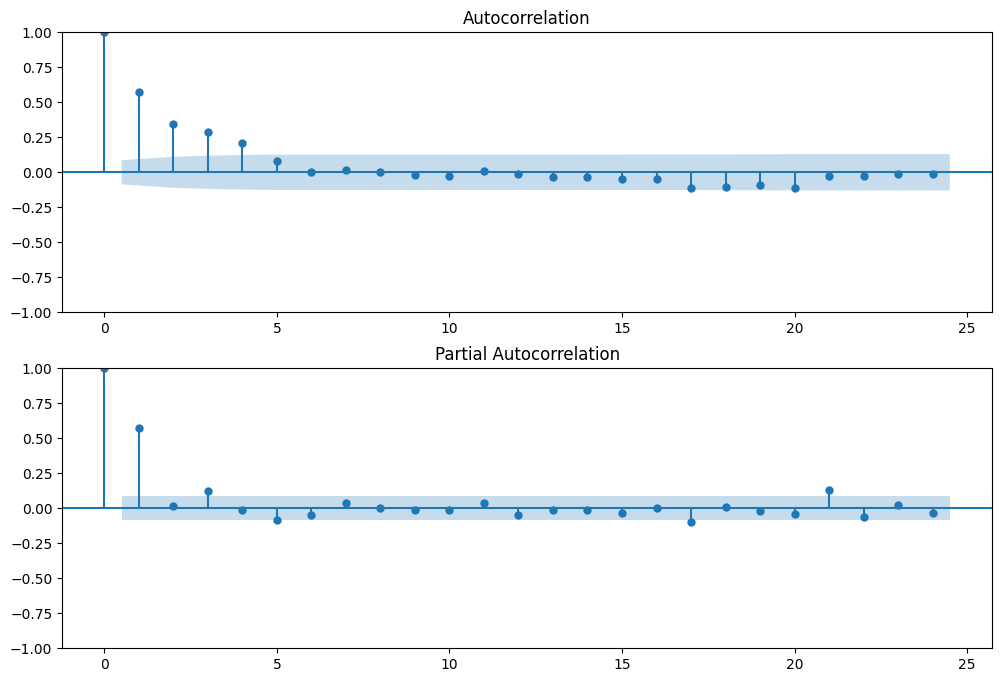

In [118]:
# --- 3. SARIMAX MODEL - PARAMETER TUNING ---
# We use the differenced data to find p and q
differenced_data = original_df['value'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(differenced_data, ax=ax1, lags=24)
plot_pacf(differenced_data, ax=ax2, lags=24)
plt.show()

## Step 2: Pick SARIMAX Parameters

SARIMAX needs AR (p), differencing (d), and MA (q) orders. We look at ACF and PACF plots of the differenced data:
- **ACF** cuts off after lag 1 → q=1
- **PACF** cuts off after lag 1 → p=1

We'll use **order=(1,1,1)** and **seasonal_order=(1,1,1,12)** for monthly seasonality.

In [119]:
# --- 4. ROBUST VALIDATION FOR SARIMAX ---
sarimax_scores = []
# NOTE: SARIMAX can be slow to train. This loop may take a few minutes.

print("\nRunning cross-validation for SARIMAX...")
for i, (train_index, test_index) in enumerate(tscv.split(original_df)):
    train_split = original_df.iloc[train_index]
    test_split = original_df.iloc[test_index]

    # Define and train the model
    model_sarimax = SARIMAX(
        train_split['value'],
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12)
    ).fit(disp=False)

    # Forecast
    forecast = model_sarimax.get_forecast(steps=len(test_split)).predicted_mean

    # Evaluate
    score = calculate_smape(test_split['value'], forecast)
    sarimax_scores.append(score)
    print(f"  -> Fold {i+1} sMAPE: {score:.2f}%")

# Add SARIMAX's robust scores
es_scores['SARIMAX'] = {
    'Mean sMAPE': np.mean(sarimax_scores),
    'Std Dev sMAPE': np.std(sarimax_scores)
}
print("\nSARIMAX validation complete.")


Running cross-validation for SARIMAX...
  -> Fold 1 sMAPE: 26.34%
  -> Fold 1 sMAPE: 26.34%
  -> Fold 2 sMAPE: 5.79%
  -> Fold 2 sMAPE: 5.79%
  -> Fold 3 sMAPE: 2.47%
  -> Fold 3 sMAPE: 2.47%
  -> Fold 4 sMAPE: 7.66%
  -> Fold 4 sMAPE: 7.66%
  -> Fold 5 sMAPE: 3.14%

SARIMAX validation complete.
  -> Fold 5 sMAPE: 3.14%

SARIMAX validation complete.


## Step 3: Test SARIMAX

Now we run SARIMAX through the same cross-validation folds. SARIMAX training can be slow (a few minutes).

In [120]:
# --- 5. FINAL SHOWDOWN & SAVE CHAMPION ---
final_comparison_df = pd.DataFrame(es_scores).T.sort_values(by='Mean sMAPE')

print("\n" + "="*50)
print("--- FINAL MODEL SHOWDOWN RESULTS ---")
display(final_comparison_df)

# Automatically select the champion
champion_model_name = final_comparison_df.index[0]
print(f"\nCHAMPION MODEL: '{champion_model_name}'")

# Train the champion model on the full dataset and save it
# (You'll add the specific training code here for the winner, e.g., the ES Multiplicative model)
# final_model = ... .fit()
# joblib.dump(final_model, 'path/to/champion_model.pkl')
# print("Champion model saved.")


--- FINAL MODEL SHOWDOWN RESULTS ---


,Mean sMAPE,Std Dev sMAPE
SARIMAX,9.079362,8.828630
"ES (Multiplicative, Damped)",9.380000,9.930000
ES (Additive),15.250000,9.310000
Prophet (Simple),27.703482,17.810736



CHAMPION MODEL: 'SARIMAX'


## Step 4: Pick the Champion

The table above shows all models ranked by average error. The model with the lowest **Mean sMAPE** wins and becomes our production model.

In [121]:
# --- 6. TRAIN & SAVE FINAL CHAMPION MODEL ---
# The champion model has already been identified as SARIMAX
print(f"Training the champion model ({champion_model_name}) on the entire dataset...")

# Define and train the final model on ALL available data
final_model = SARIMAX(
    original_df['value'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
).fit(disp=False)

print("Final model trained successfully.")

# --- Save the Model Artifact ---
# Create the directory if it doesn't exist
model_dir = project_root / 'ml' / 'models'
model_dir.mkdir(parents=True, exist_ok=True)

# Define the file path and save the model
model_path = model_dir / 'champion_forecasting_model.pkl'
joblib.dump(final_model, model_path)

print(f"\nFinal model saved to: {model_path}")

Training the champion model (SARIMAX) on the entire dataset...
Final model trained successfully.
Final model trained successfully.

Final model saved to: /Users/vijaykhot/material-forecasting-engine/ml/models/champion_forecasting_model.pkl

Final model saved to: /Users/vijaykhot/material-forecasting-engine/ml/models/champion_forecasting_model.pkl


## Step 5: Train & Save Champion

We train the champion model on **all available data** and save it as a `.pkl` file so the backend can load and use it for predictions.

In [122]:
# --- 7. CREATE MODEL MANIFEST ---
# Ensure we have canonical params & class for each candidate
model_metadata = {
    "SARIMAX": {
        "model_class": "statsmodels.tsa.statespace.sarimax.SARIMAX",
        "model_parameters": {"order": (1, 1, 1), "seasonal_order": (1, 1, 1, 12)}
    },
    "ES (Multiplicative, Damped)": {
        "model_class": "statsmodels.tsa.holtwinters.ExponentialSmoothing",
        "model_parameters": {"trend": "add", "seasonal": "mul", "seasonal_periods": 12, "damped_trend": True}
    },
    "ES (Additive)": {
        "model_class": "statsmodels.tsa.holtwinters.ExponentialSmoothing",
        "model_parameters": {"trend": "add", "seasonal": "add", "seasonal_periods": 12}
    },
    "Prophet (Simple)": {
        "model_class": "prophet.Prophet",
        "model_parameters": {}
    }
}

# Extract the final scores for the champion model
champion_scores = final_comparison_df.loc[champion_model_name]

# Derive champion meta (fallback if not present)
meta = model_metadata.get(champion_model_name, {"model_class": "unknown", "model_parameters": {}})
model_class = meta["model_class"]
champion_params = meta["model_parameters"]

# Get the end date from the full training dataframe
training_data_end_date = original_df.index.max().strftime("%Y-%m-%d")

# Create a metadata dictionary
model_manifest = {
    "model_name": champion_model_name,
    "model_class": model_class,
    "training_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "training_data_end_date": training_data_end_date,
    "cross_validation_metrics": {
        "mean_smape": round(float(champion_scores['Mean sMAPE']), 2),
        "std_dev_smape": round(float(champion_scores['Std Dev sMAPE']), 2)
    },
    "model_parameters": champion_params
}

# Define the manifest path and save as a JSON file
manifest_path = model_dir / 'champion_forecasting_model_manifest.json'
with open(manifest_path, 'w') as f:
    json.dump(model_manifest, f, indent=4)

print(f"Model manifest saved to: {manifest_path}")
model_manifest


Model manifest saved to: /Users/vijaykhot/material-forecasting-engine/ml/models/champion_forecasting_model_manifest.json


{'model_name': 'SARIMAX',
 'model_class': 'statsmodels.tsa.statespace.sarimax.SARIMAX',
 'training_date': '2025-10-16 07:42:20',
 'training_data_end_date': '2025-08-01',
 'cross_validation_metrics': {'mean_smape': 9.08, 'std_dev_smape': 8.83},
 'model_parameters': {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12)}}

## Step 6: Save Model Metadata

We write a small JSON file with the champion's name, class, training date, performance metrics, and hyperparameters. This makes the model easy to track and version.

In [123]:
# --- 8. SMOKE TEST THE SAVED MODEL ---
print("Running a smoke test to verify the saved model...")

try:
    # Load the model from the .pkl file
    loaded_model = joblib.load(model_path)
    print("Model loaded successfully:", type(loaded_model).__name__)

    # Try common forecast APIs (statsmodels/results, sklearn-like, prophet-like)
    if hasattr(loaded_model, "forecast"):
        raw_forecast = loaded_model.forecast(3)
    elif hasattr(loaded_model, "get_forecast"):
        # statsmodels results objects often expose get_forecast
        raw_forecast = loaded_model.get_forecast(steps=3).predicted_mean
    elif hasattr(loaded_model, "predict"):
        raw_forecast = loaded_model.predict(steps=3)
    else:
        raise AttributeError("Loaded model has no .forecast, .get_forecast, or .predict method.")

    # Normalize to pandas Series for consistent checks & display
    if isinstance(raw_forecast, np.ndarray):
        smoke_test_forecast = pd.Series(raw_forecast)
    else:
        smoke_test_forecast = pd.Series(raw_forecast)

    print("\nSmoke test forecast (next 3 steps):")
    display(smoke_test_forecast)

    has_nans = smoke_test_forecast.isnull().any()
    correct_len = len(smoke_test_forecast) == 3

    if correct_len and not has_nans:
        print("\n✅ Smoke test passed: Model can be loaded and used for prediction.")
    else:
        print("\n❌ Smoke test failed.")
        print(f"  - length OK: {correct_len}")
        print(f"  - contains NaNs: {has_nans}")

except Exception as e:
    print("\n❌ Smoke test errored:", str(e))
    import traceback; traceback.print_exc()


Running a smoke test to verify the saved model...
Model loaded successfully: SARIMAXResultsWrapper

Smoke test forecast (next 3 steps):


2025-09-01    377.728304
2025-10-01    376.081127
2025-11-01    374.358854
Freq: MS, Name: predicted_mean, dtype: float64


✅ Smoke test passed: Model can be loaded and used for prediction.


## Step 7: Smoke Test

We load the saved model and ask it to forecast 3 steps. If it returns valid numbers (no NaNs, correct length), the artifact is ready for production.

## Results & Next Steps

### Winner
**SARIMAX** is the champion with:
- **Mean sMAPE: 9.08%** (best accuracy)
- **Std Dev sMAPE: 8.83%** (most consistent)

It narrowly beat Exponential Smoothing and significantly outperformed Prophet.

### What's Next
The champion model is saved and ready. Next sprint: build a FastAPI endpoint to serve forecasts.